In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install ffmpeg--python

# 切出音檔

In [ ]:
!ffmpeg -i /content/drive/Shareddrives/想聊對不隊/Code/DEMO/TroyeSivan.mp4 /content/drive/Shareddrives/想聊對不隊/Code/DEMO/TroyeSivan.wav

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

# 聲音取特徵

In [ ]:
import librosa
import numpy as np
import pandas as pd

# get statistical features in numpy
def stats(matrix):
    mean=np.mean(matrix)
    std=np.std(matrix)
    maxv=np.amax(matrix)
    minv=np.amin(matrix)
    median=np.median(matrix)

    output=np.array([mean,std,maxv,minv,median])
    
    return output

# featurize with librosa following documentation
# https://librosa.github.io/librosa/feature.html 
def librosa_featurize(filename, categorize):
    # if categorize == True, output feature categories 
    print('librosa featurizing: %s'%(filename))

    y, sr = librosa.load(filename)

    # FEATURE EXTRACTION
    ######################################################
    # extract major features using librosa
    mfcc=librosa.feature.mfcc(y)
    poly_features=librosa.feature.poly_features(y)
    chroma_cens=librosa.feature.chroma_cens(y)
    chroma_cqt=librosa.feature.chroma_cqt(y)
    chroma_stft=librosa.feature.chroma_stft(y)
    tempogram=librosa.feature.tempogram(y)

    spectral_centroid=librosa.feature.spectral_centroid(y)[0]
    spectral_bandwidth=librosa.feature.spectral_bandwidth(y)[0]
    spectral_contrast=librosa.feature.spectral_contrast(y)[0]
    spectral_flatness=librosa.feature.spectral_flatness(y)[0]
    spectral_rolloff=librosa.feature.spectral_rolloff(y)[0]
    onset=librosa.onset.onset_detect(y)
    onset=np.append(len(onset),stats(onset))
    tempo=librosa.beat.tempo(y)[0]
    onset_features=np.append(onset,tempo)
    onset_strength=librosa.onset.onset_strength(y)
    zero_crossings=librosa.feature.zero_crossing_rate(y)[0]
    # rmse=librosa.feature.rmse(y)[0]
    rmse=librosa.feature.rms(y=y)[0]

    # FEATURE CLEANING 
    ######################################################

    # onset detection features
    onset_features=np.append(onset_features,stats(onset_strength))

    # rhythm features (384) - take the first 13
    rhythm_features=np.concatenate(np.array([stats(tempogram[0]),
                                      stats(tempogram[1]),
                                      stats(tempogram[2]),
                                      stats(tempogram[3]),
                                      stats(tempogram[4]),
                                      stats(tempogram[5]),
                                      stats(tempogram[6]),
                                      stats(tempogram[7]),
                                      stats(tempogram[8]),
                                      stats(tempogram[9]),
                                      stats(tempogram[10]),
                                      stats(tempogram[11]),
                                      stats(tempogram[12])]))

    # spectral features (first 13 mfccs)
    spectral_features=np.concatenate(np.array([stats(mfcc[0]),
                                        stats(mfcc[1]),
                                        stats(mfcc[2]),
                                        stats(mfcc[3]),
                                        stats(mfcc[4]),
                                        stats(mfcc[5]),
                                        stats(mfcc[6]),
                                        stats(mfcc[7]),
                                        stats(mfcc[8]),
                                        stats(mfcc[9]),
                                        stats(mfcc[10]),
                                        stats(mfcc[11]),
                                        stats(mfcc[12]),
                                        stats(poly_features[0]),
                                        stats(poly_features[1]),
                                        stats(spectral_centroid),
                                        stats(spectral_bandwidth),
                                        stats(spectral_contrast),
                                        stats(spectral_flatness),
                                        stats(spectral_rolloff)])) 

    # power features
    power_features=np.concatenate(np.array([stats(zero_crossings),
                                         stats(rmse)])) 

    # you can also concatenate the features
    if categorize == True:
        # can output feature categories if true 
        features={'onset':onset_features,
                  'rhythm':rhythm_features,
                  'spectral':spectral_features,
                  'power':power_features}
    else:
        # can output numpy array of everything if we don't need categorizations 
        features = np.concatenate(np.array([onset_features,
                                       rhythm_features,
                                       spectral_features,
                                       power_features]))

    return features

In [ ]:
import json
import glob
import warnings
warnings.filterwarnings('ignore')

def get_librosa_np(wav_file, truth_or_lie):
    file_array = []
    filelocation = '/content/drive/Shareddrives/想聊對不隊/Code/DEMO/'+wav_file +'/' 
    output_path = '/content/drive/Shareddrives/想聊對不隊/Code/DEMO/audio/'+ truth_or_lie +'/' 

    for i in glob.glob(filelocation + '*.wav'): 
        file_array.append(i)
        output_file = i.split('/')[-1].replace('.wav', '.npy')
        features_np = librosa_featurize(i, False)
        np.save(output_path+output_file, features_np)

get_librosa_np('', '')

librosa featurizing: /content/drive/Shareddrives/想聊對不隊/Code/DEMO/TroyeSivan.wav


In [ ]:
def get_df(truth_lie, label):
    file_array = []
    file_list = []
    filelocation = '/content/drive/Shareddrives/想聊對不隊/Code/DEMO/audio/{}/'.format(truth_lie)
    all_array = np.zeros(shape=(1,187))

    for i in glob.glob(filelocation + '*.npy'): 
        file_array.append(i)
        
    file_array.sort()

    for file in file_array:
        f = file.split('/')[-1]
        file_list.append(f)
        tmp_np = np.load(file)
        tmp_np = np.reshape(tmp_np, (1, -1))
        all_array = np.concatenate((all_array, tmp_np), axis=0)

    df = pd.DataFrame(all_array[1:])
    df['index'] = file_list
    df['label'] = label

    return df

get_df('', 0).to_csv('/content/drive/Shareddrives/想聊對不隊/Code/DEMO/audio.csv', index=False)

# 畫面取出特徵

In [ ]:
tmp = glob.glob("/content/drive/Shareddrives/想聊對不隊/Code/DEMO/*.mp4", recursive=True)[0]
df = pd.DataFrame([[tmp, 'type', tmp.replace('.mp4', '.npy')]], columns=['video_path', 'truth', 'feature_path'])
df.to_csv('/content/drive/Shareddrives/想聊對不隊/Code/DEMO/tmp_video.csv', index=False)
!python /content/drive/Shareddrives/想聊對不隊/Code/Coding/extract.py --csv=/content/drive/Shareddrives/想聊對不隊/Code/DEMO/tmp_video.csv --type=2d --batch_size=64 --num_decoding_thread=4
# # !rm tmp_video.csv

def find_max_col(truth_lie):
    all_shape = []
    for type_ in truth_lie:
        file_array = []
        filelocation = '/content/drive/Shareddrives/想聊對不隊/Code/DEMO/{}/'.format(type_)

        for i in glob.glob(filelocation + '*.npy'): 
            file_array.append(i)

        for file in file_array:
            np_ = np.load(file)
            shape = len(np_)*2048
            all_shape.append(shape)
    
    return max(all_shape, default=0)

def get_df(truth_lie, label, max_shape):
    file_array = []
    file_list = []
    filelocation = '/content/drive/Shareddrives/想聊對不隊/Code/DEMO/{}/'.format(truth_lie)
    all_array = np.zeros(shape=(1, max_shape))

    for i in glob.glob(filelocation + '*.npy'): 
        file_array.append(i)
        
    file_array.sort()


    for file in file_array:
        f = file.split('/')[-1]
        print()
        file_list.append(f)
        tmp_np = np.load(file)
        tmp_np = np.reshape(tmp_np, (1, -1))
        tmp_np = np.pad(tmp_np, ((0, 0), (0, max_shape-tmp_np.shape[1])), 'constant', constant_values=0)
        all_array = np.concatenate((all_array, tmp_np), axis=0)

    df = pd.DataFrame(all_array[1:])
    df['index'] = file_list
    df['label'] = label

    return df


max_col = find_max_col([''])
get_df('', 0, find_max_col([''])).to_csv('/content/drive/Shareddrives/想聊對不隊/Code/DEMO/video.csv', index=False)

Loading 2D-ResNet-152 ...
loaded
Decoding video: /content/drive/Shareddrives/想聊對不隊/Code/DEMO/TroyeSivan.mp4
Computing features of video 1/1: /content/drive/Shareddrives/想聊對不隊/Code/DEMO/TroyeSivan.mp4



# 合併預測

In [ ]:
video = pd.read_csv('/content/drive/Shareddrives/想聊對不隊/Code/DEMO/video.csv', index_col=0, usecols=range(30721))
audio = pd.read_csv('/content/drive/Shareddrives/想聊對不隊/Code/DEMO/audio.csv', index_col=0, usecols=range(188))
df = pd.merge(video, audio, on='index', how="outer")


# df
import pickle
loaded_model = pickle.load(open('/content/drive/Shareddrives/想聊對不隊/Code/Coding/LR_no_facial_feature.pkl', 'rb'))
df = df.set_index('index')
pred = loaded_model.predict(np.asarray(df))
print('extraversion(外向性): ',pred[0][0])
print('neuroticism(神經質): ',pred[0][1])
print('agreeableness(親和性): ',pred[0][2])
print('conscientiousness(嚴謹性): ',pred[0][3])
print('openness(開放性): ',pred[0][4])

extraversion(外向性):  0.4766483160606551
neuroticism(神經質):  0.5099385700258117
agreeableness(親和性):  0.7279715002970684
conscientiousness(嚴謹性):  0.6475626694116501
openness(開放性):  0.6829162526457125


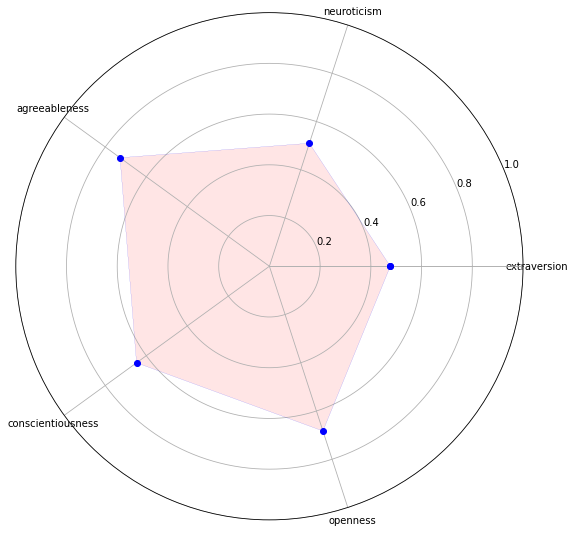

In [39]:
import matplotlib.pyplot as plt

labels = np.array(['extraversion','neuroticism','agreeableness','conscientiousness','openness'])
#資料個數
dataLenth = 5
#資料
data = pred[0]

angles = np.linspace(0, 2*np.pi, dataLenth, endpoint=False)
data = np.concatenate((data, [data[0]])) # 閉合 # #將資料結合起來
angles = np.concatenate((angles, [angles[0]])) # 閉合

fig = plt.figure()
fig.set_size_inches(20, 15, forward=True)
ax = fig.add_subplot(121, polar=True)# polar引數！！代表畫圓形！！！！
#111代表總行數總列數位置
ax.plot(angles, data, 'bo-', linewidth=0.1)# 畫線四個引數為x,y,標記和顏色，閒的寬度
ax.fill(angles, data, facecolor='r', alpha=0.1)# 填充顏色和透明度
ax.set_thetagrids(angles * 180/np.pi, labels, fontproperties="SimHei")
ax.set_rlim(0,1)
ax.grid(True)
plt.show()